<a href="https://colab.research.google.com/github/sebi061/VideoAdEngagement/blob/main/3_Analysis/3_all_Ads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Installations ###
#####################

# xg boost
!pip install xgboost

# shap
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.3 MB/s eta 0:00:00


In [ ]:
### Import relevant packages ###
################################

import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder


from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix

In [ ]:
### Set data directory
##################

# connect to drive
from google.colab import drive
drive.mount('/content/drive')

# set data directory
data_dir_feat =  '/content/drive/MyDrive/VideoAdEngagement/1_Extracted_Data/Extracted_Features'
data_dir_stat =  '/content/drive/MyDrive/VideoAdEngagement/1_Downloaded_Data/3_Engagement_Statistics'

Mounted at /content/drive


In [ ]:
## Load and concat all feature files ###
#########################################

# define function
def load_concat_df(level, files):
  for i, file in enumerate(files):
    if i==0:
      df_final = pd.read_csv(os.path.join(data_dir_feat, f'{level}_features_{file}.csv'), index_col = 0)
    else:
      df_additional = pd.read_csv(os.path.join(data_dir_feat, f'{level}_features_{file}.csv'), index_col = 0)

      df_final = pd.concat([df_final, df_additional], ignore_index=True, axis = 0)

  return df_final


# files
files = ['hyundai', 'porsche', 'audi', 'bmw',
         'vw', 'mercedes', 'honda', 'ford',
         'skoda', 'ferrari',
         'nike', 'adidas', 'puma', 'underarmour',
         'asics', 'converse', 'timberland', 'salomon',
         'gymshark', 'gopro', 'redbull', 'monsterenergy']


# load feature dfs
low_level_df = load_concat_df(level = 'low_level', files = files)
mid_level_df = load_concat_df(level = 'mid_level', files = files)
high_level_df = load_concat_df(level = 'high_level', files = files)
object_level_df = load_concat_df(level = 'object', files = files)

# concat all
df_feat = low_level_df.merge(mid_level_df, on='video_id').merge(object_level_df, on='video_id').merge(high_level_df, on = 'video_id')

In [ ]:
### Load stats file and merge with feature file ###
###################################################

# load
df_stats_sports = pd.read_csv(os.path.join(data_dir_stat, 'df_sports_stats.csv'), index_col = 0)
df_stats_cars = pd.read_csv(os.path.join(data_dir_stat, 'df_cars_stats.csv'), index_col = 0)
df_stats_all = pd.concat([df_stats_sports, df_stats_cars], ignore_index=True, axis = 0)

# merge
df_full = df_stats_all.merge(df_feat, on = 'video_id')

{'ferrari': 0.10696004568159122, 'adidas': 0.047656850469988826, 'redbull': 0.04316218155762098, 'converse': 0.039190370409335845, 'vw': 0.051199967520731596, 'hyundai': 0.04875188961949696, 'porsche': 0.051860653329514485, 'nike': 0.038237334513139286, 'salomon': 0.027680984866053276, 'puma': 0.042461379937335335, 'gymshark': 0.03972274995300461, 'audi': 0.07846626775446079, 'skoda': 0.04208681360892751, 'timberland': 0.02688981648085376, 'ford': 0.05211933642036357, 'bmw': 0.04486897480702443, 'asics': 0.031046005702921743, 'mercedes': 0.05727768733844177, 'monsterenergy': 0.046387200193050634, 'underarmour': 0.026911869381116647, 'honda': 0.025077718343563697, 'gopro': 0.04228838647794189}
{'ferrari': 0.025583332407194903, 'adidas': 0.010685935301643499, 'redbull': 0.015037889400515944, 'converse': 0.02462663946901246, 'vw': 0.019449579151675733, 'hyundai': 0.061494727334989334, 'porsche': 0.014571599142867537, 'nike': 0.013151206455209435, 'salomon': 0.012633131384185332, 'puma': 0

<Axes: ylabel='Density'>

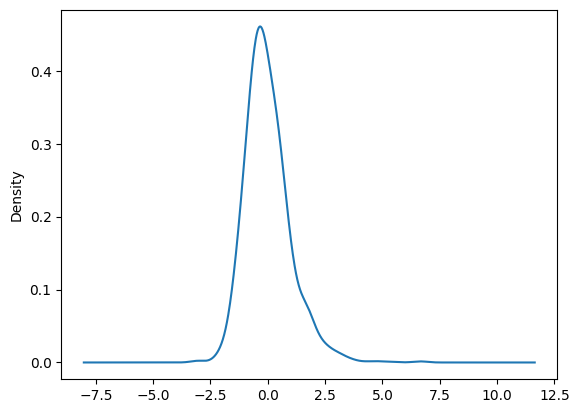

In [ ]:
### Normalization accross all brands ###
########################################

# extract brand means
brand_means = {b: df_full.loc[df_full['brand'] == b, 'eng_score'].mean() for b in set(df_full.brand)}
print(brand_means)

# extract brand stds
brand_std = {b: df_full.loc[df_full['brand'] == b, 'eng_score'].std() for b in set(df_full.brand)}
print(brand_std)

# normalization function
def mu_sig_normalization(example):
  norm_value = (example['eng_score'] - brand_means[example['brand']]) / brand_std[example['brand']]
  #norm_value = example['eng_score'] - brand_means[example['brand']]

  return norm_value

# apply normalization
df_full['norm_eng_score'] = df_full.apply(mu_sig_normalization, axis = 1)

# plot
df_full['norm_eng_score'].plot.kde(bw_method=0.3)

In [ ]:
### Normalize all features accross brands ###
#############################################

# create copy to store normalized values to
df_full_norm = df_full[['video_id', 'brand', 'views', 'likes', 'comments', 'eng_score', 'norm_eng_score']].copy()

# function to subtract feature mean per brand
def feature_mu_sig_norm(example):

  # option 1: mean sigma normalization
  if stds[example[0]] == 0:
    result = example[1] - means[example[0]]

  else:
     result = (example[1] - means[example[0]]) / stds[example[0]]

  # option 2: mu mormalization
  #result = example[1] - means[example[0]]

  return result

# loop over all features to normalize by brand mean
for feat in df_full.columns[6:-1]: # strat at 6

  # get feature mean values per brand
  means = {b: df_full.loc[df_full['brand'] == b, feat].mean() for b in set(df_full.brand)}
  stds =  {b: df_full.loc[df_full['brand'] == b, feat].std() for b in set(df_full.brand)}

  # store to new dataframe
  df_additional = pd.DataFrame({feat:df_full[['brand', feat]].apply(feature_mu_sig_norm, axis = 1)})
  df_full_norm = pd.concat([df_full_norm, df_additional], axis = 1)

In [ ]:
### Define engagement classes ###
#################################

# wrote function
def eng_classes(example):
  if example['norm_eng_score'] < df_full_norm['norm_eng_score'].quantile(1/3):
    cls = 'low'

  elif example['norm_eng_score'] >= df_full_norm['norm_eng_score'].quantile(2/3):
    cls = 'high'

  else:
    cls = 'mid'

  return cls

# apply to df
df_full_norm['eng_class'] = df_full_norm.apply(eng_classes, axis = 1)

# check walue counts
df_full_norm['eng_class'].value_counts()

mid     573
high    573
low     573
Name: eng_class, dtype: int64

# Classification of 3 engagement classes

In [ ]:
### Select all features from dataframe ###
##########################################

ds = df_full_norm.iloc[:, 7:-1]

In [ ]:
### train test split ###
########################

from sklearn.model_selection import train_test_split

# select x and y variables
X, y = ds, df_full_norm[['eng_class']]

# Encode y to numeric
y = OrdinalEncoder(categories = [['low', 'mid', 'high']]).fit_transform(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, shuffle = True)

In [ ]:
### Cross validated hyperparameter tuning ###
#############################################

# Select parameters spaces for tuning

params = {'max_depth': np.arange(2, 8, 1),
          'learning_rate': [0.001, 0.05, 0.1],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': np.arange(500, 2500,500),
          'eta': np.arange(0.2,0.8,0.1),
          'gamma': np.arange(0.2,0.8,0.1),
          'min_child_weight' : range(1,6,1)}

In [ ]:
### Parameter search
# initialize classifier
xgbclf = XGBClassifier(booster = 'gbtree',
                     objective = 'multi:softmax',
                     num_class = 3,
                     eval_metric = 'auc',
                     random_state = 42)

# initialize parameter search
gs = RandomizedSearchCV(estimator=xgbclf,
                             param_distributions =params,
                             scoring='accuracy',
                             n_jobs = 4,
                             cv = 3,
                             n_iter = 40,
                             verbose=1,
                             random_state = 42)

# apply cross-validated hyperparameter search
gs.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'eta': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'gamma': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.001, 0.05, 0.1],
                                        'max_depth': array([2, 3, 4, 5, 6, 7]),
                                        'min_child_weight': range(1, 6),
                                        'n_estimators': array([ 500, 1000, 1500, 2000]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
# best parameters
print(gs.best_params_)

# best accuracy score
print(gs.best_score_)

{'subsample': 0.5, 'n_estimators': 1000, 'min_child_weight': 4, 'max_depth': 6, 'learning_rate': 0.001, 'gamma': 0.8000000000000003, 'eta': 0.6000000000000001, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8999999999999999}
0.43640897755610975


In [ ]:
### Fit model with best parameter combination on the test set ###
#################################################################

# initialize model with best found parameter combination
best_parameters = gs.best_params_
model = XGBClassifier(booster = 'gbtree',
                     objective = 'multi:softmax',
                     num_class = 3,
                     eval_metric = 'auc',
                     learning_rate = best_parameters['learning_rate'],
                     max_depth = best_parameters['max_depth'],
                     n_estimators = best_parameters['n_estimators'],
                     min_child_weight = best_parameters['min_child_weight'],
                     colsample_bytree = best_parameters['colsample_bytree'],
                     colsample_bylevel = best_parameters['colsample_bylevel'],
                     subsample = best_parameters['subsample'],
                     eta = best_parameters['eta'],
                     gamma = best_parameters['gamma'],
                     random_state = 42)

In [ ]:
# train model on whole train set
model.fit(X_train, y_train)

# final prediction on test set
y_pred = model.predict(X_test)


# acc
acc = accuracy_score(y_test, y_pred)

In [ ]:
### Evalution ###
#################
matrix = confusion_matrix(y_test, y_pred)
per_class_acc = matrix.diagonal()/matrix.sum(axis=1)


print(f"Total accuracy: {acc*100:.2f} %" )
print(f"Accuracy low engagement class: {per_class_acc[0] * 100:.2f} %")
print(f"Accuracy mid engagement class: {per_class_acc[1] * 100:.2f} %")
print(f"Accuracy high engagement class: {per_class_acc[2] * 100:.2f} %")

Total accuracy: 44.57 %
Accuracy low engagement class: 46.06 %
Accuracy mid engagement class: 42.77 %
Accuracy high engagement class: 44.94 %


# Classification of high and low engagment class - 2 way

In [ ]:
### Remove middle class to get clearer distinction ###
######################################################

df_full_norm_2 = df_full_norm.loc[df_full_norm['eng_class'] != 'mid'].reset_index(drop = True)

In [ ]:
### Model fitting and cross validation ###
##########################################
# https://www.anyscale.com/blog/how-to-tune-hyperparameters-on-xgboost
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

ds = df_full_norm_2.iloc[:, 7:-1]

In [ ]:
### train test split ###
########################

from sklearn.model_selection import train_test_split

# select x and y variables
X, y = ds, df_full_norm_2[['eng_class']]

# Encode y to numeric
y = OrdinalEncoder(categories = [['low', 'high']]).fit_transform(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, shuffle = True)

In [ ]:
### Cross validated hyperparameter tuning ###
#############################################

# Select parameters spaces for tuning
params = {'max_depth': np.arange(2, 8, 1),
          'learning_rate': [0.001, 0.05, 0.1],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': np.arange(500, 2500,500),
          'eta': np.arange(0.2,0.8,0.1),
          'gamma': np.arange(0.2,0.8,0.1),
          'min_child_weight' : range(1,6,1)}



In [ ]:
### Parameter search
# initialize classifier
xgbclf_2 = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     random_state = 42)

# initialize parameter search
gs_2 = RandomizedSearchCV(estimator=xgbclf_2,
                             param_distributions =params,
                             scoring='accuracy',
                             n_jobs = 4,
                             cv = 3,
                             n_iter = 40,
                             verbose=1,
                             random_state = 42)

# apply cross-validated hyperparameter search
gs_2.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'eta': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'gamma': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.001, 0.05, 0.1],
                                        'max_depth': array([2, 3, 4, 5, 6, 7]),
                                        'min_child_weight': range(1, 6),
                                        'n_estimators': array([ 500, 1000, 1500, 2000]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
# best parameters
print(gs_2.best_params_)

# best accuracy score
print(gs_2.best_score_)

{'subsample': 0.7999999999999999, 'n_estimators': 1000, 'min_child_weight': 4, 'max_depth': 6, 'learning_rate': 0.001, 'gamma': 0.7000000000000002, 'eta': 0.30000000000000004, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.5}
0.6196824864441837


In [ ]:
### Fit model with best parameter combination on the test set ###
#################################################################

# initialize model with best found parameter combination
best_parameters = gs_2.best_params_
model_2 = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     learning_rate = best_parameters['learning_rate'],
                     max_depth = best_parameters['max_depth'],
                     n_estimators = best_parameters['n_estimators'],
                     min_child_weight = best_parameters['min_child_weight'],
                     colsample_bytree = best_parameters['colsample_bytree'],
                     colsample_bylevel = best_parameters['colsample_bylevel'],
                     subsample = best_parameters['subsample'],
                     eta = best_parameters['eta'],
                     gamma = best_parameters['gamma'],
                     random_state = 42)

In [ ]:
# train model on whole train set
model_2.fit(X_train, y_train)

# final prediction on test set
y_pred = model_2.predict(X_test)


# acc
acc = accuracy_score(y_test, y_pred)

In [ ]:
### Evalution ###
#################
matrix = confusion_matrix(y_test, y_pred)
per_class_acc = matrix.diagonal()/matrix.sum(axis=1)


print(f"Total accuracy: {acc*100:.2f} %" )
print(f"Accuracy low engagement class: {per_class_acc[0] * 100:.2f} %")
print(f"Accuracy high engagement class: {per_class_acc[1] * 100:.2f} %")

Total accuracy: 60.76 %
Accuracy low engagement class: 58.51 %
Accuracy high engagement class: 63.46 %


# Train on low level, semantic and psychological features individually

In [ ]:
### low level features ###
##########################

In [ ]:
### Model fitting and cross validation ###
ds_low = df_full_norm_2.iloc[:, 7:34]

In [ ]:
# select x and y variables
X, y = ds_low, df_full_norm_2[['eng_class']]

# Encode y to numeric
y = OrdinalEncoder(categories = [['low', 'high']]).fit_transform(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, shuffle = True)

In [ ]:
### Cross validated hyperparameter tuning

# Select parameters spaces for tuning
params = {'max_depth': np.arange(2, 8, 1),
          'learning_rate': [0.001, 0.05, 0.1],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': np.arange(500, 2500,500),
          'eta': np.arange(0.2,0.8,0.1),
          'gamma': np.arange(0.2,0.8,0.1),
          'min_child_weight' : range(1,6,1)}


In [ ]:
### Parameter search
# initialize classifier
xgbclf_low = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     random_state = 42)

# initialize parameter search
gs_low = RandomizedSearchCV(estimator=xgbclf_low,
                             param_distributions =params,
                             scoring='accuracy',
                             n_jobs = 4,
                             cv = 3,
                             n_iter = 40,
                             verbose=1,
                             random_state = 42)

# apply cross-validated hyperparameter search
gs_low.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'eta': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'gamma': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.001, 0.05, 0.1],
                                        'max_depth': array([2, 3, 4, 5, 6, 7]),
                                        'min_child_weight': range(1, 6),
                                        'n_estimators': array([ 500, 1000, 1500, 2000]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
### Fit model with best parameter combination on the test set

# initialize model with best found parameter combination
best_parameters_low = gs_low.best_params_
model_low = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     learning_rate = best_parameters_low['learning_rate'],
                     max_depth = best_parameters_low['max_depth'],
                     n_estimators = best_parameters_low['n_estimators'],
                     min_child_weight = best_parameters_low['min_child_weight'],
                     colsample_bytree = best_parameters_low['colsample_bytree'],
                     colsample_bylevel = best_parameters_low['colsample_bylevel'],
                     subsample = best_parameters_low['subsample'],
                     eta = best_parameters_low['eta'],
                     gamma = best_parameters_low['gamma'],
                     random_state = 42)

In [ ]:
# train model on whole train set
model_low.fit(X_train, y_train)

# final prediction on test set
y_pred = model_low.predict(X_test)


# acc
acc = accuracy_score(y_test, y_pred)

In [ ]:
### Evalution
matrix = confusion_matrix(y_test, y_pred)
per_class_acc = matrix.diagonal()/matrix.sum(axis=1)


print(f"Total accuracy: {acc*100:.2f} %" )
print(f"Accuracy low engagement class: {per_class_acc[0] * 100:.2f} %")
print(f"Accuracy high engagement class: {per_class_acc[1] * 100:.2f} %")

Total accuracy: 45.93 %
Accuracy low engagement class: 30.32 %
Accuracy high engagement class: 64.74 %


In [ ]:
### Mid level features ###
##########################

In [ ]:
### Model fitting and cross validation ###
ds_mid = df_full_norm_2.iloc[:, 35:506]

In [ ]:
# select x and y variables
X, y = ds_mid, df_full_norm_2[['eng_class']]

# Encode y to numeric
y = OrdinalEncoder(categories = [['low', 'high']]).fit_transform(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, shuffle = True)

In [ ]:
### Cross validated hyperparameter tuning

# Select parameters spaces for tuning
params = {'max_depth': np.arange(2, 8, 1),
          'learning_rate': [0.001, 0.05, 0.1],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': np.arange(500, 2500,500),
          'eta': np.arange(0.2,0.8,0.1),
          'gamma': np.arange(0.2,0.8,0.1),
          'min_child_weight' : range(1,6,1)}


In [ ]:
### Parameter search
# initialize classifier
xgbclf_mid = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     random_state = 42)

# initialize parameter search
gs_mid = RandomizedSearchCV(estimator=xgbclf_mid,
                             param_distributions =params,
                             scoring='accuracy',
                             n_jobs = 4,
                             cv = 3,
                             n_iter = 40,
                             verbose=1,
                             random_state = 42)

# apply cross-validated hyperparameter search
gs_mid.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'eta': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'gamma': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.001, 0.05, 0.1],
                                        'max_depth': array([2, 3, 4, 5, 6, 7]),
                                        'min_child_weight': range(1, 6),
                                        'n_estimators': array([ 500, 1000, 1500, 2000]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
### Fit model with best parameter combination on the test set

# initialize model with best found parameter combination
best_parameters_mid = gs_mid.best_params_
model_mid = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     learning_rate = best_parameters_mid['learning_rate'],
                     max_depth = best_parameters_mid['max_depth'],
                     n_estimators = best_parameters_mid['n_estimators'],
                     min_child_weight = best_parameters_mid['min_child_weight'],
                     colsample_bytree = best_parameters_mid['colsample_bytree'],
                     colsample_bylevel = best_parameters_mid['colsample_bylevel'],
                     subsample = best_parameters_mid['subsample'],
                     eta = best_parameters_mid['eta'],
                     gamma = best_parameters_mid['gamma'],
                     random_state = 42)

In [ ]:
# train model on whole train set
model_mid.fit(X_train, y_train)

# final prediction on test set
y_pred = model_mid.predict(X_test)


# acc
acc = accuracy_score(y_test, y_pred)

In [ ]:
### Evalution
matrix = confusion_matrix(y_test, y_pred)
per_class_acc = matrix.diagonal()/matrix.sum(axis=1)


print(f"Total accuracy: {acc*100:.2f} %" )
print(f"Accuracy low engagement class: {per_class_acc[0] * 100:.2f} %")
print(f"Accuracy high engagement class: {per_class_acc[1] * 100:.2f} %")

Total accuracy: 63.37 %
Accuracy low engagement class: 61.17 %
Accuracy high engagement class: 66.03 %


In [ ]:
### High level features ###
##########################

In [ ]:
### Model fitting and cross validation ###
ds_high = df_full_norm_2.iloc[:, 507:-1]

In [ ]:
# select x and y variables
X, y = ds_high, df_full_norm_2[['eng_class']]

# Encode y to numeric
y = OrdinalEncoder(categories = [['low', 'high']]).fit_transform(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, shuffle = True)

In [ ]:
### Cross validated hyperparameter tuning

# Select parameters spaces for tuning
params = {'max_depth': np.arange(2, 8, 1),
          'learning_rate': [0.001, 0.05, 0.1],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': np.arange(500, 2500,500),
          'eta': np.arange(0.2,0.8,0.1),
          'gamma': np.arange(0.2,0.8,0.1),
          'min_child_weight' : range(1,6,1)}

In [ ]:
### Parameter search
# initialize classifier
xgbclf_high = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     random_state = 42)

# initialize parameter search
gs_high = RandomizedSearchCV(estimator=xgbclf_high,
                             param_distributions =params,
                             scoring='accuracy',
                             n_jobs = 4,
                             cv = 3,
                             n_iter = 40,
                             verbose=1,
                             random_state = 42)

# apply cross-validated hyperparameter search
gs_high.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'eta': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'gamma': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.001, 0.05, 0.1],
                                        'max_depth': array([2, 3, 4, 5, 6, 7]),
                                        'min_child_weight': range(1, 6),
                                        'n_estimators': array([ 500, 1000, 1500, 2000]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
### Fit model with best parameter combination on the test set

# initialize model with best found parameter combination
best_parameters_high = gs_high.best_params_
model_high = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     learning_rate = best_parameters_high['learning_rate'],
                     max_depth = best_parameters_high['max_depth'],
                     n_estimators = best_parameters_high['n_estimators'],
                     min_child_weight = best_parameters_high['min_child_weight'],
                     colsample_bytree = best_parameters_high['colsample_bytree'],
                     colsample_bylevel = best_parameters_high['colsample_bylevel'],
                     subsample = best_parameters_high['subsample'],
                     eta = best_parameters_high['eta'],
                     gamma = best_parameters_high['gamma'],
                     random_state = 42)

In [ ]:
# train model on whole train set
model_high.fit(X_train, y_train)

# final prediction on test set
y_pred = model_high.predict(X_test)


# acc
acc = accuracy_score(y_test, y_pred)

In [ ]:
### Evalution
matrix = confusion_matrix(y_test, y_pred)
per_class_acc = matrix.diagonal()/matrix.sum(axis=1)


print(f"Total accuracy: {acc*100:.2f} %" )
print(f"Accuracy low engagement class: {per_class_acc[0] * 100:.2f} %")
print(f"Accuracy high engagement class: {per_class_acc[1] * 100:.2f} %")

Total accuracy: 53.78 %
Accuracy low engagement class: 42.02 %
Accuracy high engagement class: 67.95 %


# Cumputing SHAP feature contributions

In [ ]:
# import libraries
import shap
import matplotlib.pyplot as plt

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
# sort the normalized engagement scores
s = df_full_norm_2['norm_eng_score'].argsort()

In [ ]:
# sample the 50 observations with the highest and 50 observations with the lowest engagement scores
high_low = list(s[:50]) + list(s[-50:])
len(high_low)

100

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


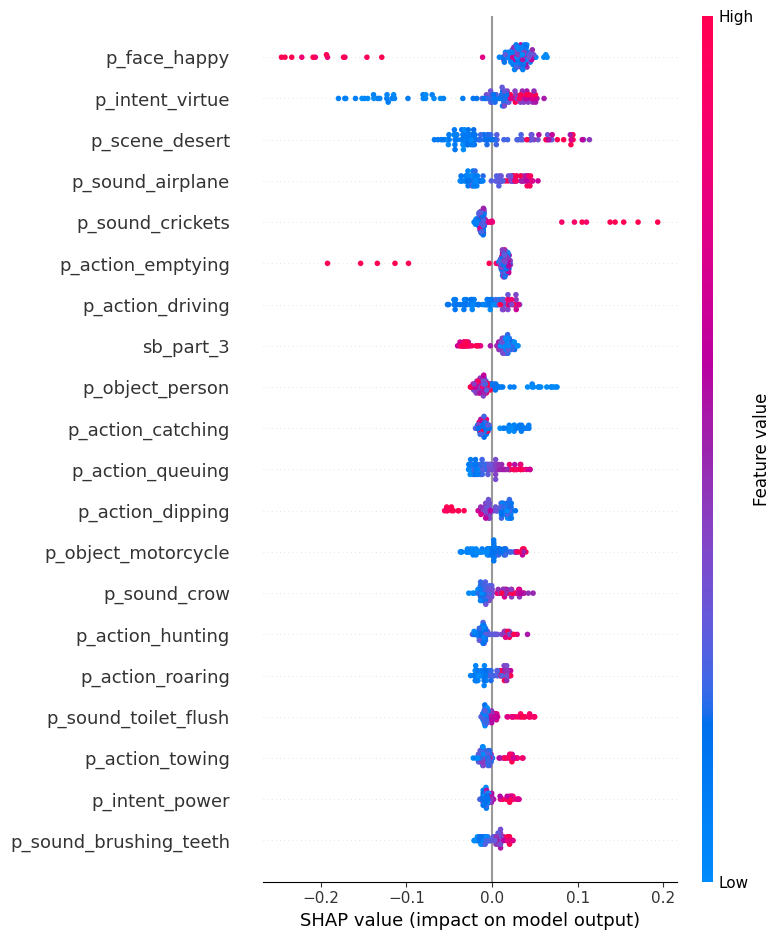

In [ ]:
X_sampled = ds.iloc[high_low,:].reset_index(drop = True)
explainer = shap.TreeExplainer(model_2)
shap_values = explainer.shap_values(X_sampled)
# summarize the effects of all the features
fig = shap.summary_plot(shap_values, X_sampled,  show = False)
plt.savefig('shape5.png')

# Pca

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# low colour
pca = PCA(n_components=3, random_state = 42)
ds_low_colour = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 7:16]), columns = [f"colour_pc_{i}" for i in range(3)])
ds_low_colour

,colour_pc_0,colour_pc_1,colour_pc_2
0,-1.375209,-0.490306,-1.498558
1,0.098105,0.912461,1.723898
2,0.945142,1.007065,0.239531
3,1.300410,1.381805,0.194604
4,0.148529,0.728966,-0.151713
...,...,...,...
1141,0.431954,0.998904,1.195064
1142,-1.464006,-1.290931,-0.525521
1143,1.602981,1.509929,-0.357361
1144,-0.859982,3.167179,0.553439


In [ ]:
# low level dynamics
pca = PCA(n_components=2, random_state = 42)
ds_low_dyn = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 16:22]), columns = [f"dynamics_pc_{i}" for i in range(2)])
ds_low_dyn

,dynamics_pc_0,dynamics_pc_1
0,-0.639345,-0.283212
1,-0.223059,-1.240287
2,0.430111,-1.218405
3,0.273809,-1.249827
4,0.112015,0.170835
...,...,...
1141,3.763107,3.126957
1142,0.210990,-0.546895
1143,-0.778565,-1.026790
1144,0.152817,0.182563


In [ ]:
# low level audio
pca = PCA(n_components=4, random_state = 42)
ds_low_audio = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 22:34]), columns = [f"audio_pc_{i}" for i in range(4)])
ds_low_audio

,audio_pc_0,audio_pc_1,audio_pc_2,audio_pc_3
0,-0.762009,-1.777261,-0.046957,-0.316483
1,3.118364,-2.239661,0.808948,0.285291
2,-1.879108,-0.800992,1.137442,-0.243181
3,-2.772948,-0.052561,0.782216,-0.885856
4,-1.647146,-1.470052,-0.458409,-0.153227
...,...,...,...,...
1141,5.964693,-0.205151,-0.690585,1.342083
1142,1.310103,4.244185,0.121926,-0.298449
1143,-1.590326,-1.324757,-0.388260,-1.502532
1144,2.678033,2.281716,-0.740716,-0.672987


In [ ]:
# mid action
pca = PCA(n_components=10, random_state = 42)
ds_mid_action = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 34:326]), columns = [f"action_pc_{i}" for i in range(10)])
ds_mid_action

,action_pc_0,action_pc_1,action_pc_2,action_pc_3,action_pc_4,action_pc_5,action_pc_6,action_pc_7,action_pc_8,action_pc_9
0,2.334214,1.476546,2.043321,-0.671973,3.004319,0.608736,0.723769,-1.224304,-0.676261,-1.708160
1,4.223742,2.316972,2.313812,-2.663081,-5.567974,1.794251,1.016270,3.139576,-1.993411,8.938985
2,2.579603,0.056762,-2.375239,0.026712,-3.132407,-3.830894,5.301616,-5.129537,3.918605,1.651531
3,-1.561328,4.098797,2.781137,3.790648,-2.384876,-1.298134,-1.045948,0.183173,-0.398153,1.898870
4,0.669066,1.457668,1.091846,-2.987464,3.035100,3.212556,-0.622956,0.959298,1.791526,-1.440248
...,...,...,...,...,...,...,...,...,...,...
1141,-8.635715,-3.239431,-1.597970,0.351712,4.437583,-2.657944,2.084172,0.247934,-1.628074,2.174023
1142,2.426261,0.934182,-2.626699,-0.583441,-1.786844,-1.158457,0.077496,-3.167568,-2.309523,-1.653410
1143,3.379926,-4.020117,-5.205861,-1.085254,-1.064057,-1.089082,2.478680,1.556598,-2.069422,1.924139
1144,-10.568076,-0.203192,-4.993527,0.380426,1.431453,-1.679931,-0.111773,-1.402977,-1.666727,2.638895


In [ ]:
# mid face
pca = PCA(n_components=4, random_state = 42)
ds_mid_face = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 326:333]), columns = [f"face_pc_{i}" for i in range(4)])
ds_mid_face

,face_pc_0,face_pc_1,face_pc_2,face_pc_3
0,-0.108827,-0.462894,-0.671912,-0.565800
1,1.740848,1.648462,-1.282369,0.207926
2,-0.194997,0.681485,0.722519,0.431086
3,1.120072,1.186807,-0.918735,0.720893
4,-0.023495,0.343941,-0.151851,-0.037362
...,...,...,...,...
1141,-0.942337,0.317825,-0.207117,0.441797
1142,-0.942337,0.317825,-0.207117,0.441797
1143,-0.942337,0.317825,-0.207117,0.441797
1144,-0.942337,0.317825,-0.207117,0.441797


In [ ]:
# mid scenes
pca = PCA(n_components=10, random_state = 42)
ds_mid_scenes = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 333:372]), columns = [f"scenes_pc_{i}" for i in range(10)])
ds_mid_scenes

,scenes_pc_0,scenes_pc_1,scenes_pc_2,scenes_pc_3,scenes_pc_4,scenes_pc_5,scenes_pc_6,scenes_pc_7,scenes_pc_8,scenes_pc_9
0,-0.645920,-0.197607,-0.217118,0.218194,3.562617,-0.365042,0.396770,-0.746479,-0.779858,-0.064706
1,2.290280,-0.987048,-0.576109,0.235832,0.972674,-2.049894,4.191917,-0.705402,-1.282874,0.090187
2,0.178815,-1.693050,-0.080826,-0.574774,1.068036,0.159042,-1.149797,-0.321574,0.518148,0.024287
3,-1.561803,-2.315767,0.919892,-0.048850,-1.353557,1.295437,0.133854,0.804233,-0.491510,0.626539
4,1.775588,-2.926454,-1.423074,-1.445648,0.189721,0.299126,1.618159,1.421381,-0.923893,-0.098364
...,...,...,...,...,...,...,...,...,...,...
1141,-1.520806,2.176749,1.430718,-1.864304,1.148224,-1.166550,-1.113334,2.054059,1.036935,-1.564177
1142,-0.054732,0.118701,0.058019,-0.274822,0.435149,0.465125,0.207970,-0.107656,-0.177416,0.390569
1143,0.335526,-0.087235,-0.334261,0.652061,0.459966,1.030179,0.201179,0.118702,-0.000641,-0.120412
1144,-2.861403,-0.116556,-0.204641,0.331700,0.924677,-0.426921,-0.451284,0.221505,0.084464,0.105298


In [ ]:
# mid sounds
pca = PCA(n_components=10, random_state = 42)
ds_mid_sounds = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 372:426]), columns = [f"sounds_pc_{i}" for i in range(10)])

In [ ]:
# mid objects
pca = PCA(n_components=10, random_state = 42)
ds_mid_objects = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 426:506]), columns = [f"objects_pc_{i}" for i in range(10)])

In [ ]:
# high intent
pca = PCA(n_components=3, random_state = 42)
ds_high_intent = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 506:515]), columns = [f"intent_pc_{i}" for i in range(3)])
ds_high_intent

,intent_pc_0,intent_pc_1,intent_pc_2
0,1.796209,0.579510,0.576841
1,0.937646,-1.139652,0.677861
2,-0.125447,-1.036878,0.980253
3,-0.521439,-0.285240,0.270001
4,2.677890,-0.075166,-0.648453
...,...,...,...
1141,-0.550799,0.261832,0.836638
1142,2.310197,-0.183254,-0.617068
1143,0.566651,0.864502,0.155912
1144,-2.368312,-0.359726,-0.243874


In [ ]:
# high mem
ds_high_mem = df_full_norm_2.iloc[:, [515]]
ds_high_mem

,mem_score
0,-0.649343
1,0.739337
2,0.948908
3,0.624449
4,0.201456
...,...
1141,-0.117443
1142,-0.067419
1143,0.154376
1144,-0.947124


In [ ]:
# high audio mood
pca = PCA(n_components=2, random_state = 42)
ds_high_audiomood = pd.DataFrame(pca.fit_transform(df_full_norm_2.iloc[:, 516:-1]), columns = [f"audiomood_pc_{i}" for i in range(2)])
ds_high_audiomood

,audiomood_pc_0,audiomood_pc_1
0,1.646134,2.606515
1,0.652179,0.943092
2,-1.457259,-0.460939
3,-1.437173,0.292511
4,2.076505,-0.965576
...,...,...
1141,-1.367303,0.758888
1142,-0.920004,0.068612
1143,2.500845,-1.197922
1144,-1.745150,-0.880552


In [ ]:
# combining all
ds_pca = pd.concat([ds_low_colour, ds_low_dyn, ds_low_audio, ds_mid_action, ds_mid_face, ds_mid_objects, ds_mid_scenes, ds_mid_sounds, ds_high_intent, ds_high_mem, ds_high_audiomood], ignore_index=False, axis = 1)
ds_pca

,colour_pc_0,colour_pc_1,colour_pc_2,dynamics_pc_0,dynamics_pc_1,audio_pc_0,audio_pc_1,audio_pc_2,audio_pc_3,action_pc_0,...,sounds_pc_6,sounds_pc_7,sounds_pc_8,sounds_pc_9,intent_pc_0,intent_pc_1,intent_pc_2,mem_score,audiomood_pc_0,audiomood_pc_1
0,-1.375209,-0.490306,-1.498558,-0.639345,-0.283212,-0.762009,-1.777261,-0.046957,-0.316483,2.334214,...,2.371992,-2.156671,-1.688885,0.605802,1.796209,0.579510,0.576841,-0.649343,1.646134,2.606515
1,0.098105,0.912461,1.723898,-0.223059,-1.240287,3.118364,-2.239661,0.808948,0.285291,4.223742,...,0.266442,1.806864,-0.611585,0.295655,0.937646,-1.139652,0.677861,0.739337,0.652179,0.943092
2,0.945142,1.007065,0.239531,0.430111,-1.218405,-1.879108,-0.800992,1.137442,-0.243181,2.579603,...,-1.407927,-0.883278,0.156004,-0.765250,-0.125447,-1.036878,0.980253,0.948908,-1.457259,-0.460939
3,1.300410,1.381805,0.194604,0.273809,-1.249827,-2.772948,-0.052561,0.782216,-0.885856,-1.561328,...,-2.067018,-1.436867,-2.839896,-0.739255,-0.521439,-0.285240,0.270001,0.624449,-1.437173,0.292511
4,0.148529,0.728966,-0.151713,0.112015,0.170835,-1.647146,-1.470052,-0.458409,-0.153227,0.669066,...,-1.950096,-2.477986,0.075176,-2.462101,2.677890,-0.075166,-0.648453,0.201456,2.076505,-0.965576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,0.431954,0.998904,1.195064,3.763107,3.126957,5.964693,-0.205151,-0.690585,1.342083,-8.635715,...,-3.215680,1.889122,-0.501150,-0.356015,-0.550799,0.261832,0.836638,-0.117443,-1.367303,0.758888
1142,-1.464006,-1.290931,-0.525521,0.210990,-0.546895,1.310103,4.244185,0.121926,-0.298449,2.426261,...,-0.043133,0.238899,-0.300836,1.906999,2.310197,-0.183254,-0.617068,-0.067419,-0.920004,0.068612
1143,1.602981,1.509929,-0.357361,-0.778565,-1.026790,-1.590326,-1.324757,-0.388260,-1.502532,3.379926,...,0.308119,-1.607846,-0.291786,-0.687280,0.566651,0.864502,0.155912,0.154376,2.500845,-1.197922
1144,-0.859982,3.167179,0.553439,0.152817,0.182563,2.678033,2.281716,-0.740716,-0.672987,-10.568076,...,-2.228146,-0.411418,1.986462,2.860255,-2.368312,-0.359726,-0.243874,-0.947124,-1.745150,-0.880552


# Fit 2 way classification model to the features reduced in dimensions

In [ ]:
### train test split ###
########################

# select x and y variables
X, y = ds_pca, df_full_norm_2[['eng_class']]

# Encode y to numeric
y = OrdinalEncoder(categories = [['low', 'high']]).fit_transform(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, shuffle = True)

In [ ]:
### Cross validated hyperparameter tuning ###
#############################################

# Select parameters spaces for tuning

params = {'max_depth': np.arange(2, 8, 1),
          'learning_rate': [0.001, 0.05, 0.1],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': np.arange(500, 2500,500),
          'eta': np.arange(0.2,0.8,0.1),
          'gamma': np.arange(0.2,0.8,0.1),
          'min_child_weight' : range(1,6,1)}

In [ ]:
### Parameter search
# initialize classifier
xgbclf_3 = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     random_state = 42)

# initialize parameter search
gs_3 = RandomizedSearchCV(estimator=xgbclf_3,
                             param_distributions =params,
                             scoring='accuracy',
                             n_jobs = 4,
                             cv = 3,
                             n_iter = 40,
                             verbose=1,
                             random_state = 42)

# apply cross-validated hyperparameter search
gs_3.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'eta': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'gamma': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.001, 0.05, 0.1],
                                        'max_depth': array([2, 3, 4, 5, 6, 7]),
                                        'min_child_weight': range(1, 6),
                                        'n_estimators': array([ 500, 1000, 1500, 2000]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
# best parameters
print(gs_3.best_params_)

# best accuracy score
print(gs_3.best_score_)

{'subsample': 0.7, 'n_estimators': 1000, 'min_child_weight': 4, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.2, 'eta': 0.30000000000000004, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.5}
0.6097275793318054


In [ ]:
### Fit model with best parameter combination on the test set ###
#################################################################

# initialize model with best found parameter combination
best_parameters = gs_3.best_params_
model_pca = XGBClassifier(booster = 'gbtree',
                     objective = 'binary:logistic',
                     eval_metric = 'auc',
                     learning_rate = best_parameters['learning_rate'],
                     max_depth = best_parameters['max_depth'],
                     n_estimators = best_parameters['n_estimators'],
                     min_child_weight = best_parameters['min_child_weight'],
                     colsample_bytree = best_parameters['colsample_bytree'],
                     colsample_bylevel = best_parameters['colsample_bylevel'],
                     subsample = best_parameters['subsample'],
                     eta = best_parameters['eta'],
                     gamma = best_parameters['gamma'],
                     random_state = 42)

In [ ]:
# train model on whole train set
model_pca.fit(X_train, y_train)

# final prediction on test set
y_pred = model_pca.predict(X_test)


# acc
acc = accuracy_score(y_test, y_pred)

In [ ]:
### Evalution ###
#################
matrix = confusion_matrix(y_test, y_pred)
per_class_acc = matrix.diagonal()/matrix.sum(axis=1)


print(f"Total accuracy: {acc*100:.2f} %" )
print(f"Accuracy low engagement class: {per_class_acc[0] * 100:.2f} %")
print(f"Accuracy high engagement class: {per_class_acc[1] * 100:.2f} %")

Total accuracy: 58.72 %
Accuracy low engagement class: 53.72 %
Accuracy high engagement class: 64.74 %


 # Shap

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


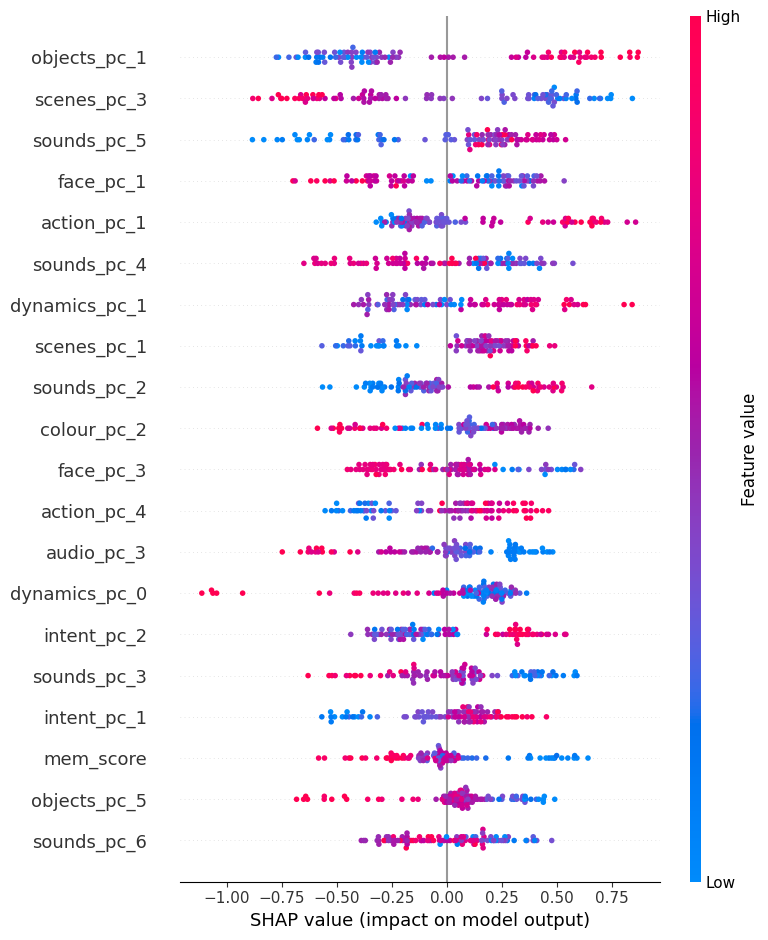

In [ ]:
X_sampled = ds_pca.iloc[high_low,:].reset_index(drop = True)
explainer = shap.TreeExplainer(model_pca)
shap_values = explainer.shap_values(X_sampled)
# summarize the effects of all the features
fig = shap.summary_plot(shap_values, X_sampled,  show = False)
plt.savefig('shape6.png')